In [1]:
import torch
from torch import nn
from Util import d2l
from rgb_anything_v1.dpt import RGBAnything
from cocoloader import cocoloader

# DINOv2
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\ProgramData\miniconda3\envs\rgb\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'
Using cache found in C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [2]:
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}


model = RGBAnything(**model_configs['vits'])
model._init_weights()

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [3]:
def get_optimizer(model, lr_base=1e-4, lr_backbone=1e-5, weight_decay=0.001):
    """
    为不同的模块设置不同的学习率
    """
    # 1. 提取 Backbone 参数 (DINOv2)
    backbone_params = model.pretrained.parameters()
    
    # 2. 提取 Head 参数 (DPTHead)
    # 注意：如果你的模型里还有其他随机初始化的层，也应归入此类
    head_params = model.depth_head.parameters()
    
    # 3. 构建参数组
    param_groups = [
        {
            'params': backbone_params, 
            'lr': lr_backbone,       # 预训练部分用小学习率
            'weight_decay': weight_decay
        },
        {
            'params': head_params, 
            'lr': lr_base,           # 随机初始化部分用大学习率
            'weight_decay': weight_decay
        }
    ]
    
    # 4. 初始化优化器 (推荐使用 AdamW，它是 ViT 系列的标准配置)
    optimizer = torch.optim.AdamW(param_groups)
    
    return optimizer

In [ ]:
train_iter = cocoloader('data/train_small', batch_size=4)
test_iter = cocoloader('data/test_small', batch_size=4)


loss/1000 153.376, train absrel 0.630, test absrel 0.000
14.3 examples/sec on [device(type='cuda', index=0)]


(153.37585618591308, 0.6300652171373368, 6.311442155719019e-07)

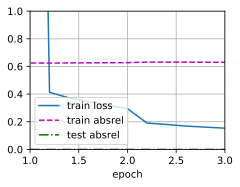

In [5]:
model.load_state_dict(torch.load('checkpoints/3.pth'))
num_epochs = 3
lr_base = 1e-4
trainer = get_optimizer(model, lr_base=lr_base, lr_backbone=lr_base/10)
d2l.train_ch13(model, train_iter, test_iter, nn.MSELoss(), trainer, num_epochs)

In [6]:
torch.save(model.state_dict(), 'checkpoints/3.pth')

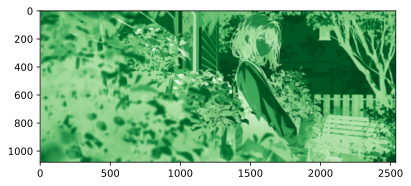

In [14]:
import cv2
from matplotlib import pyplot as plt
raw_img = cv2.imread('2025_08_08_02_02_IMG_8783.png')
g_pred = model.infer_image(raw_img)


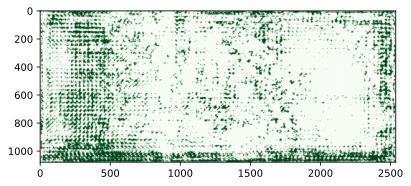

In [15]:

plt.imshow(g_pred, cmap='Greens')

In [8]:
# norm = lambda x: (x / 255.0 - 0.456) / 0.224
# def absrel(y_hat, y, threshold = 5):
#     with torch.no_grad():
#         denorm = lambda x: ((x * 0.224 + 0.456) * 255).clamp(0, 255).to(torch.uint8).to(torch.float32)  
#         y, y_hat = denorm(y), denorm(y_hat)
#         mask = y >= threshold
#         abs_rel = torch.log(0.05 / torch.mean(torch.abs(y_hat[mask] - y[mask]) / y[mask])) / 10 + 1
#     return abs_rel.item()
# absrel(norm(torch.tensor([255.0, 0])), norm(torch.tensor([5.0 + 1e-6, 255.0])))

In [9]:
# batch = next(iter(train_iter))

In [10]:
# with torch.no_grad():
#     y_pred = model(batch[0].to('cuda'))
#     y = batch[1].to('cuda')


In [11]:
# absrel(y_pred, y)